# Importing Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
import tensorflow as tf

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Attention
from tensorflow.keras.models import Model, Sequential

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df['sentiment'] = [1 if sentiment == 'positive' else 0 for sentiment in df['sentiment']]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Initial Data Analysis

In [5]:
import seaborn as sns

<AxesSubplot:xlabel='sentiment', ylabel='count'>

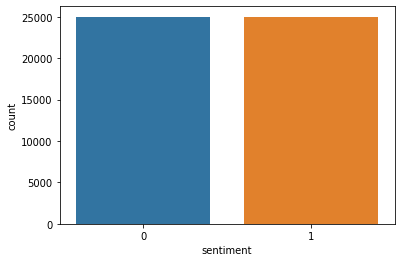

In [6]:
sns.countplot(x='sentiment', data=df) 

In [7]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

# Text Preprocessing

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_review(review):
    review = re.sub(r'[^a-zA-Z]', ' ', review)  
    review = review.lower()  
    words = word_tokenize(review)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words  # Return as a list for Word2Vec training


In [9]:
tokenized_corpus = [preprocess_review(review) for review in tqdm(df['review'])]

100%|██████████| 50000/50000 [01:19<00:00, 627.25it/s]


# 1. CBOW Model Creation

In [10]:
cbow_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=300,
    window=7,
    min_count=2,
    workers=4,
    sg=0  # CBOW
)

In [11]:
def get_sentence_vector(sentence, model):
    vector_size = model.vector_size
    vec = np.zeros(vector_size)
    count = 0
    
    for word in sentence:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    
    return vec / count if count > 0 else vec

X = np.array([get_sentence_vector(sentence, cbow_model) for sentence in tokenized_corpus])
y = df['sentiment'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape

(40000, 300)

In [14]:
y_train.shape

(40000,)

# 2. LSTM & Attention

In [15]:
from tensorflow.keras.layers import Reshape

def attention_layer(inputs):
    query, value = inputs, inputs
    attention = Attention()([query, value])
    return attention

input_layer = Input(shape=(300,))
reshaped_input = Reshape((300, 1))(input_layer)  # Fix input shape for LSTM

lstm = Bidirectional(LSTM(128, return_sequences=True))(reshaped_input)
attn = attention_layer(lstm)
dropout = Dropout(0.4)(attn)
flatten = tf.keras.layers.Flatten()(dropout)  # Ensure output shape matches Dense layer
output_layer = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 300, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 300, 256)     133120      reshape[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 300, 256)     0           bidirectional[0][0]              
                                                                 bidirectional[0][0]          

In [16]:
model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
500/500 [==============================] - 353s 701ms/step - loss: 0.6909 - accuracy: 0.5135 - val_loss: 0.5635 - val_accuracy: 0.7276
Epoch 2/15
500/500 [==============================] - 353s 707ms/step - loss: 0.4750 - accuracy: 0.7820 - val_loss: 0.4229 - val_accuracy: 0.8150
Epoch 3/15
500/500 [==============================] - 351s 702ms/step - loss: 0.4084 - accuracy: 0.8227 - val_loss: 0.3756 - val_accuracy: 0.8376
Epoch 4/15
500/500 [==============================] - 348s 696ms/step - loss: 0.3838 - accuracy: 0.8329 - val_loss: 0.3654 - val_accuracy: 0.8455
Epoch 5/15
500/500 [==============================] - 348s 697ms/step - loss: 0.3651 - accuracy: 0.8459 - val_loss: 0.3508 - val_accuracy: 0.8518
Epoch 6/15
500/500 [==============================] - 350s 699ms/step - loss: 0.3637 - accuracy: 0.8476 - val_loss: 0.3334 - val_accuracy: 0.8593
Epoch 7/15
500/500 [==============================] - 350s 701ms/step - loss: 0.3477 - accuracy: 0.8557 - val_loss: 0.3380 -

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

313/313 [==============================] - 45s 143ms/step - loss: 0.3175 - accuracy: 0.8634
Test Accuracy: 0.8634


In [18]:
# Save trained model
def save_model(model, filename="sentiment_model.h5"):
    model.save(filename)
    print("Model saved successfully!")

save_model(model)

Model saved successfully!


In [19]:
# Load model for future predictions
def load_model(filename="sentiment_model.h5"):
    return tf.keras.models.load_model(filename)

# Load model when needed
model = load_model()

In [20]:
def predict_sentiment(review, model, vectorizer):
    processed_review = preprocess_review(review)
    review_vector = np.array([get_sentence_vector(processed_review, vectorizer)])
    
    prediction = model.predict(review_vector)
    sentiment = "Positive" if prediction[0] > 0.5 else "Negative"

    print(f"Review: {review}")
    print(f"Processed Review: {processed_review}")
    print(f"Predicted Sentiment: {sentiment}\n")

In [21]:
# Example reviews for sentiment prediction
reviews = [
    "I hate this movie so much!", 
    "This film was absolutely fantastic!",  
    "One of the best movies I've ever seen!",
    "Waste of time, terrible plot and acting.",
    "film is bad",
    "film is helpfull",
    "film is useless",
    "film is good",
    "film is bad",
]

# Predict sentiment for multiple reviews
for review in reviews:
    predict_sentiment(review, model, cbow_model)

Review: I hate this movie so much!
Processed Review: ['hate', 'movie', 'much']
Predicted Sentiment: Negative

Review: This film was absolutely fantastic!
Processed Review: ['film', 'absolutely', 'fantastic']
Predicted Sentiment: Positive

Review: One of the best movies I've ever seen!
Processed Review: ['one', 'best', 'movie', 'ever', 'seen']
Predicted Sentiment: Positive

Review: Waste of time, terrible plot and acting.
Processed Review: ['waste', 'time', 'terrible', 'plot', 'acting']
Predicted Sentiment: Negative

Review: film is bad
Processed Review: ['film', 'bad']
Predicted Sentiment: Negative

Review: film is helpfull
Processed Review: ['film', 'helpfull']
Predicted Sentiment: Positive

Review: film is useless
Processed Review: ['film', 'useless']
Predicted Sentiment: Negative

Review: film is good
Processed Review: ['film', 'good']
Predicted Sentiment: Positive

Review: film is bad
Processed Review: ['film', 'bad']
Predicted Sentiment: Negative

